C:\Users\enorton\AppData\Local\Temp\ipykernel_23052\1836317821.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data, x='Transported', y=column, palette='Set1')
C:\Users\enorton\AppData\Local\Temp\ipykernel_23052\1836317821.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data, x='Transported', y=column, palette='Set1')
C:\Users\enorton\AppData\Local\Temp\ipykernel_23052\1836317821.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_data, x='Transported', y=column, palette='Set1')
C:\Users\enorton\Ap

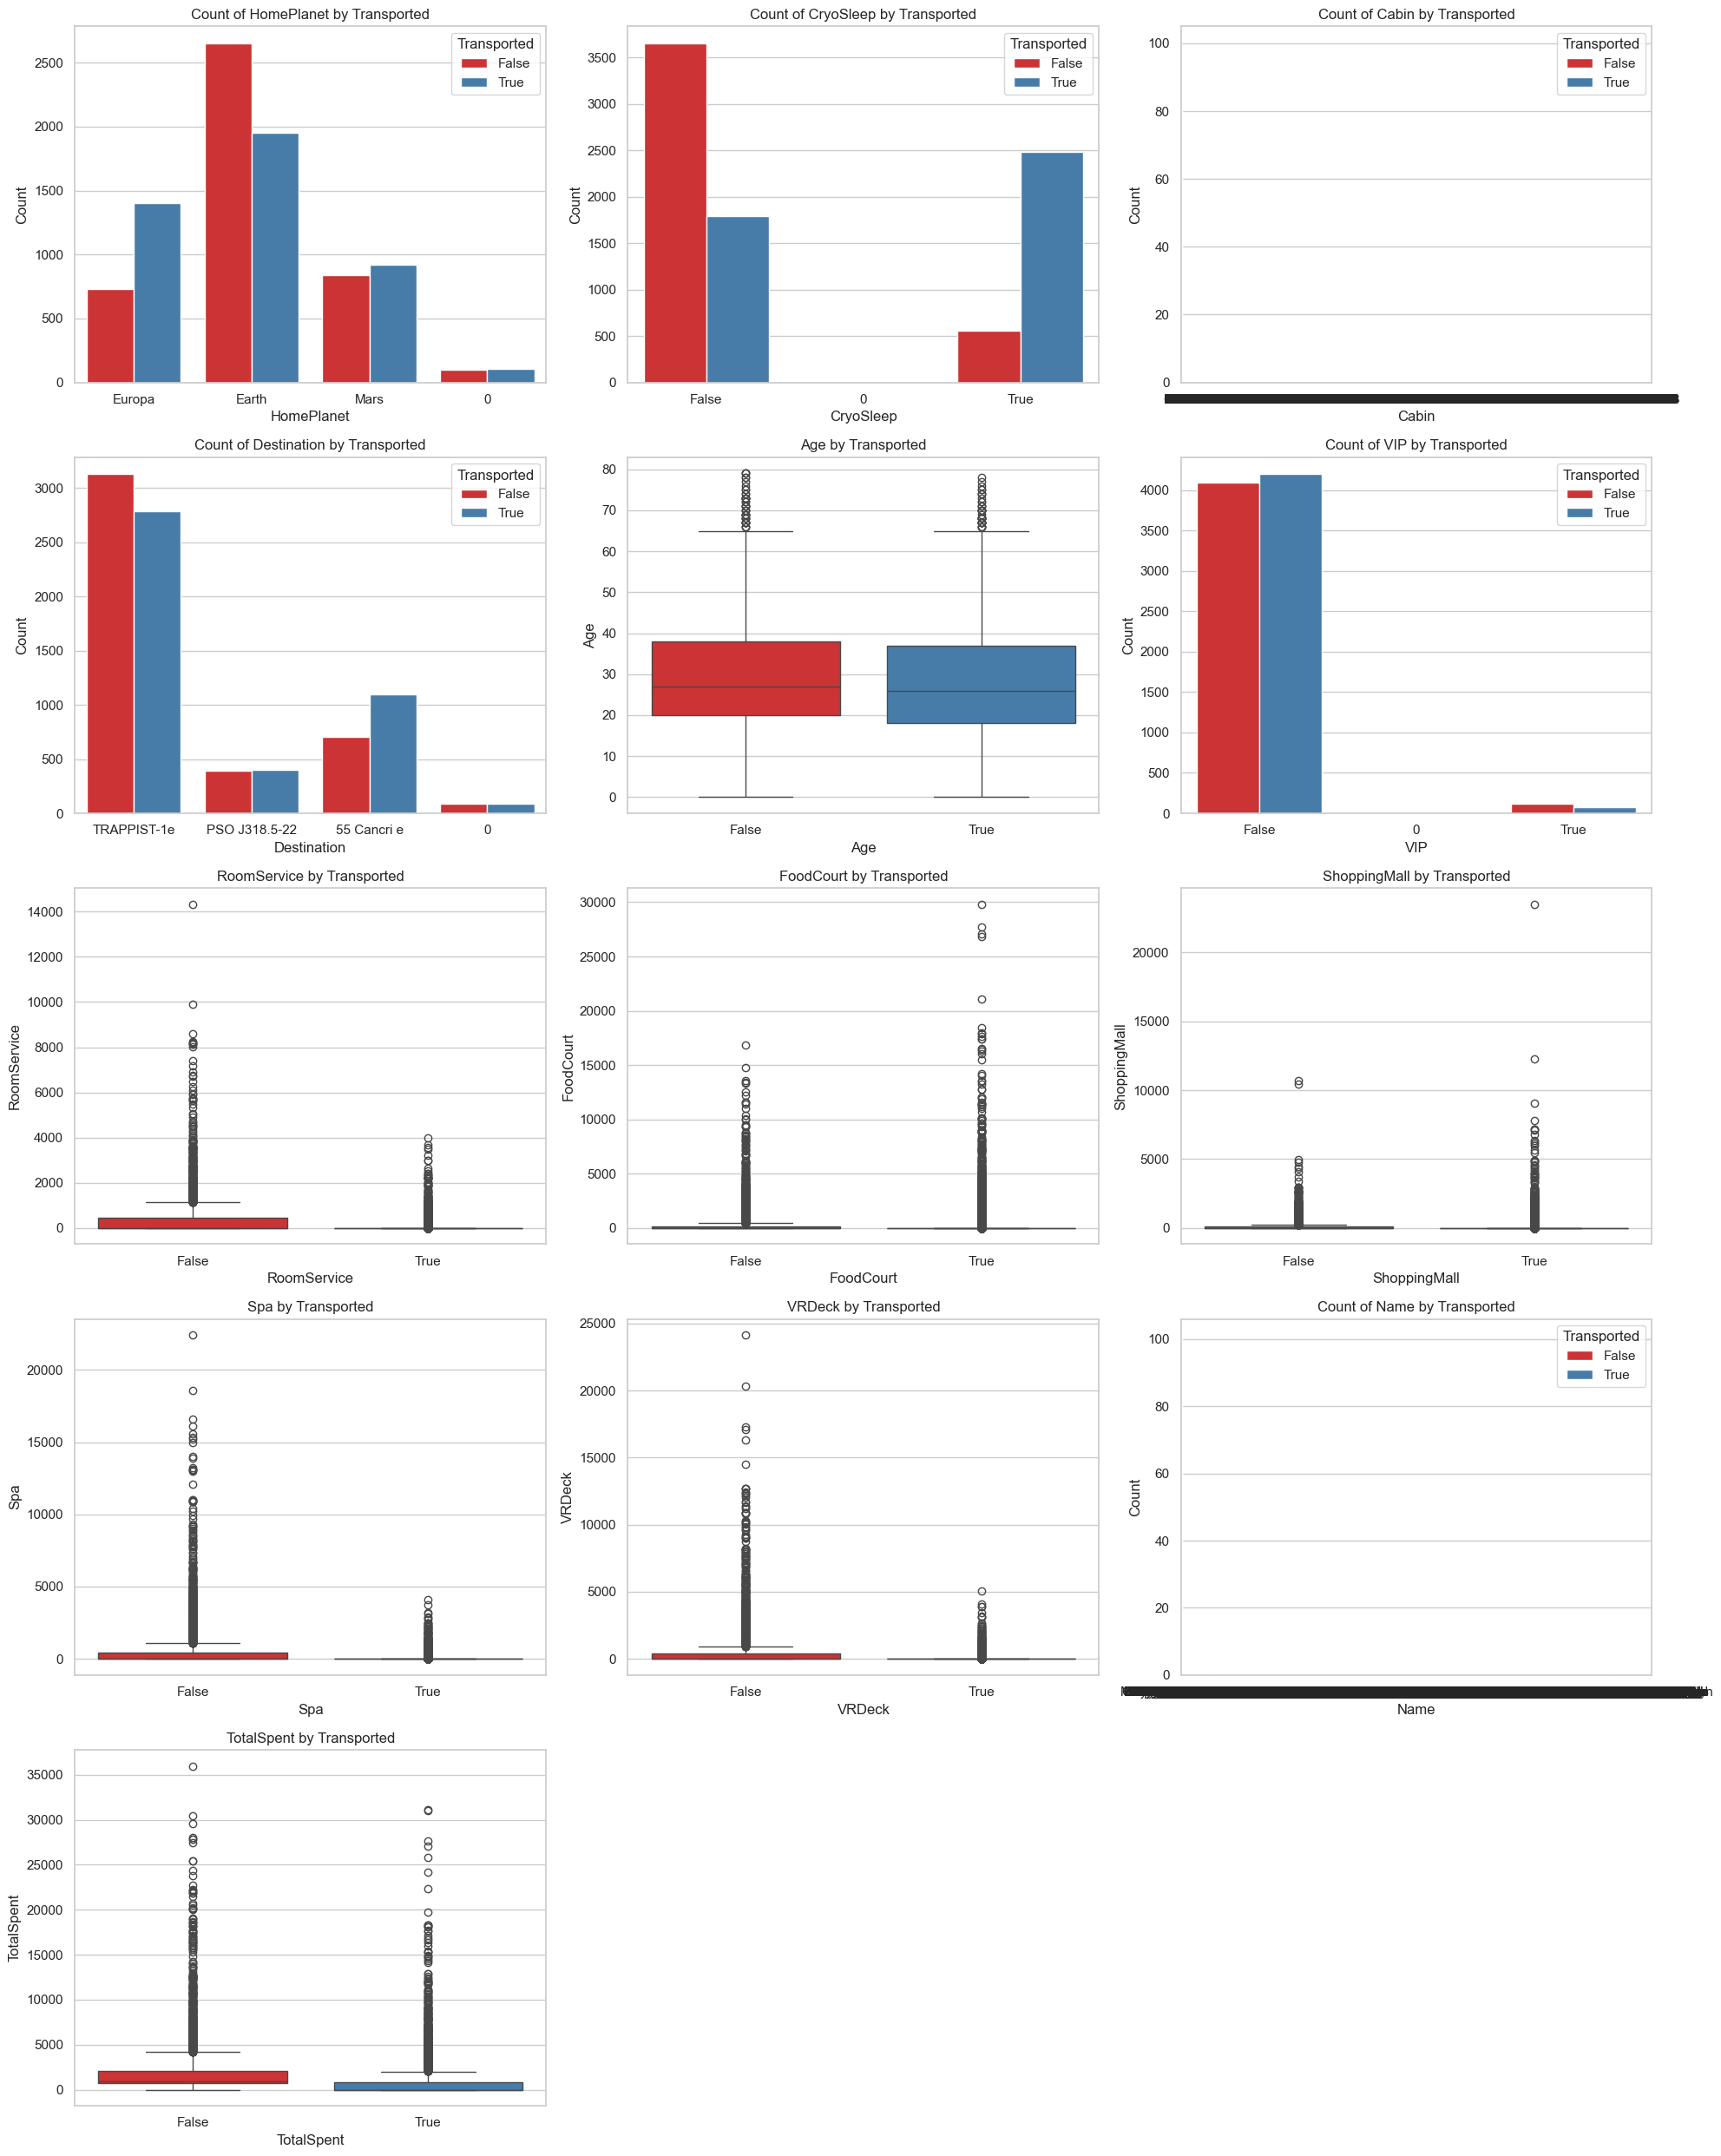

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_data = pd.read_csv('train.csv')

# Feature engineering (if needed)
def feature_engineering(data):
    data.fillna(0, inplace=True)  # Fill missing values
    data['TotalSpent'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck']
    return data

train_data = feature_engineering(train_data)

# Set the style of seaborn
sns.set(style="whitegrid")

# List of columns to plot against 'Transported'
columns_to_plot = train_data.columns.drop(['PassengerId', 'Transported'])

# Create a figure with subplots
num_cols = 3  # Number of columns for subplots
num_rows = (len(columns_to_plot) + num_cols - 1) // num_cols  # Calculate number of rows needed

plt.figure(figsize=(20, num_rows * 5))

for i, column in enumerate(columns_to_plot):
    plt.subplot(num_rows, num_cols, i + 1)
    
    if train_data[column].dtype == 'object':  # Categorical variable
        sns.countplot(data=train_data, x=column, hue='Transported', palette='Set1')
        plt.title(f'Count of {column} by Transported')
    else:  # Numerical variable
        sns.boxplot(data=train_data, x='Transported', y=column, palette='Set1')
        plt.title(f'{column} by Transported')

    plt.xlabel(column)
    plt.ylabel('Count' if train_data[column].dtype == 'object' else column)

plt.tight_layout()
plt.show()

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
import optuna

# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Check the columns in the DataFrame
print("Train Data Columns:", train_data.columns)
print("Test Data Columns:", test_data.columns)

# Feature engineering
def feature_engineering(data):
    # Example: Fill missing values and create new features based on available columns
    data.fillna(0, inplace=True)  # Fill missing values
    # Create a new feature based on existing columns
    data['TotalSpent'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck']
    return data

train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

# Convert categorical columns to string type to avoid mixed types
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin', 'Name']
for col in categorical_cols:
    train_data[col] = train_data[col].astype(str)
    test_data[col] = test_data[col].astype(str)

# Split features and target
X = train_data.drop('Transported', axis=1)  # Use 'Transported' as the target variable
y = train_data['Transported']

# Identify numerical columns
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpent']

# Create a column transformer with handle_unknown='ignore'
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)  # Ignore unknown categories
    ])

# Create a pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', RandomForestClassifier(random_state=42))])

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define objective function for Bayesian optimization
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
    
    # Fit the model using the pipeline
    pipeline.set_params(classifier=model)
    pipeline.fit(X_train, y_train)
    
    y_val_pred = pipeline.predict_proba(X_val)
    return log_loss(y_val, y_val_pred)

# Optimize hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Train final model with best parameters
best_params = study.best_params
final_model = RandomForestClassifier(**best_params, random_state=42)

# Fit the final model using the pipeline
pipeline.set_params(classifier=final_model)
pipeline.fit(X, y)

# Prepare submission
test_predictions = pipeline.predict_proba(test_data)

submission = pd.DataFrame(test_predictions, columns=['class_0', 'class_1'])  # Adjust based on your classes
submission.to_csv('sample_submission.csv', index=False)

[I 2024-11-07 13:03:58,874] A new study created in memory with name: no-name-00d9b8f8-8289-4599-a997-b8322cf5e030


Train Data Columns: Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')
Test Data Columns: Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')


[I 2024-11-07 13:03:59,790] Trial 0 finished with value: 0.5548620548265513 and parameters: {'n_estimators': 94, 'max_depth': 26}. Best is trial 0 with value: 0.5548620548265513.
[I 2024-11-07 13:04:00,090] Trial 1 finished with value: 0.6574502795550364 and parameters: {'n_estimators': 62, 'max_depth': 4}. Best is trial 0 with value: 0.5548620548265513.
[I 2024-11-07 13:04:00,253] Trial 2 finished with value: 0.573456229218162 and parameters: {'n_estimators': 16, 'max_depth': 14}. Best is trial 0 with value: 0.5548620548265513.
[I 2024-11-07 13:04:00,508] Trial 3 finished with value: 0.5663166543539492 and parameters: {'n_estimators': 33, 'max_depth': 21}. Best is trial 0 with value: 0.5548620548265513.
[I 2024-11-07 13:04:00,644] Trial 4 finished with value: 0.6827832330499197 and parameters: {'n_estimators': 26, 'max_depth': 1}. Best is trial 0 with value: 0.5548620548265513.
[I 2024-11-07 13:04:00,889] Trial 5 finished with value: 0.5829049548652355 and parameters: {'n_estimators':

In [11]:
# Prepare submission
# Assuming 'PassengerId' is in the test_data and you have predictions for 'Transported'
test_predictions = pipeline.predict(test_data)  # Get predictions (True/False)

# Create a DataFrame for submission
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],  # Ensure this matches the sample submission
    'Transported': test_predictions  # Use the predictions directly
})

# Save to CSV
submission.to_csv('sample_submission.csv', index=False)